# Dataset 1: SMS Spam Classification (Baseline vs Hyperparameter Optimization)

## Objective
The goal of this experiment is to evaluate spam detection performance on an SMS dataset using a TF-IDF + Logistic Regression pipeline. A baseline model is first established, followed by hyperparameter optimization to analyze its impact on accuracy and spam recall.

## Environment Setup
This section imports the required Python libraries for data handling, model training, evaluation, and visualization.

In [9]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

## Dataset Loading and Preprocessing
The SMS spam dataset is loaded and minimally preprocessed. Labels are converted into numeric form (spam = 1, ham = 0), and irrelevant columns are removed. No advanced text preprocessing is applied, as TF-IDF performs tokenization internally.

In [10]:
df1 = pd.read_csv("/content/spam.csv", encoding="latin-1")

# Keep only label and text columns
df1 = df1[['v1', 'v2']]
df1.columns = ['label', 'text']

# Convert labels to numeric
df1['label'] = df1['label'].str.lower().map({'ham': 0, 'spam': 1})

df1.head(), df1['label'].value_counts()

(   label                                               text
 0      0  Go until jurong point, crazy.. Available only ...
 1      0                      Ok lar... Joking wif u oni...
 2      1  Free entry in 2 a wkly comp to win FA Cup fina...
 3      0  U dun say so early hor... U c already then say...
 4      0  Nah I don't think he goes to usf, he lives aro...,
 label
 0    4825
 1     747
 Name: count, dtype: int64)

## Train-Test Split
The dataset is split into training and testing sets using an 80/20 ratio. Stratification is applied to preserve the original class distribution and ensure fair evaluation.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    df1['text'],
    df1['label'],
    test_size=0.2,
    random_state=42,
    stratify=df1['label']
)

## Baseline Model
A TF-IDF vectorizer combined with Logistic Regression is used as the baseline model. This approach is computationally efficient and widely used for text classification tasks.

In [12]:
baseline = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english")),
    ("clf", LogisticRegression(max_iter=1000))
])

baseline.fit(X_train, y_train)
pred = baseline.predict(X_test)

print("Baseline accuracy:", accuracy_score(y_test, pred))
print(classification_report(y_test, pred))
print(confusion_matrix(y_test, pred))

Baseline accuracy: 0.967713004484305
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       966
           1       1.00      0.76      0.86       149

    accuracy                           0.97      1115
   macro avg       0.98      0.88      0.92      1115
weighted avg       0.97      0.97      0.97      1115

[[966   0]
 [ 36 113]]


### Baseline Results
The baseline model achieves strong overall accuracy. However, analysis of the confusion matrix and classification report shows that a noticeable number of spam messages are misclassified as legitimate messages. This motivates the use of hyperparameter optimization to improve spam recall.

## Hyperparameter Optimization
To improve spam detection performance, RandomizedSearchCV is applied to tune TF-IDF and Logistic Regression parameters. The objective is to improve spam recall while maintaining high overall accuracy.

In [13]:
param_dist = {
    "tfidf__ngram_range": [(1,1), (1,2)],
    "tfidf__min_df": [1, 2, 5],
    "tfidf__max_df": [0.8, 0.9, 1.0],
    "clf__C": [0.1, 1, 10],
    "clf__class_weight": [None, "balanced"]
}

search = RandomizedSearchCV(
    baseline,
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1,
    random_state=42
)

search.fit(X_train, y_train)

best_model = search.best_estimator_
pred_best = best_model.predict(X_test)

print("Best parameters:", search.best_params_)
print("Tuned accuracy:", accuracy_score(y_test, pred_best))
print(classification_report(y_test, pred_best))
print(confusion_matrix(y_test, pred_best))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters: {'tfidf__ngram_range': (1, 2), 'tfidf__min_df': 5, 'tfidf__max_df': 0.8, 'clf__class_weight': None, 'clf__C': 10}
Tuned accuracy: 0.9820627802690582
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       0.99      0.87      0.93       149

    accuracy                           0.98      1115
   macro avg       0.99      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115

[[965   1]
 [ 19 130]]


### Tuned Model Results
Hyperparameter optimization improves both accuracy and spam recall compared to the baseline model. In particular, the tuned model significantly reduces the number of spam messages misclassified as legitimate messages.

## Model Comparison
Baseline and tuned models are compared using accuracy and spam recall to clearly visualize performance differences.

In [14]:
results_df = pd.DataFrame({
    "Model": ["Baseline", "Tuned"],
    "Accuracy": [0.9677, 0.9820],
    "Spam Recall": [0.76, 0.87]
})

results_df

,Model,Accuracy,Spam Recall
0,Baseline,0.9677,0.76
1,Tuned,0.9820,0.87


<Axes: title={'center': 'Dataset 1: Baseline vs Tuned Model Performance'}, xlabel='Model'>

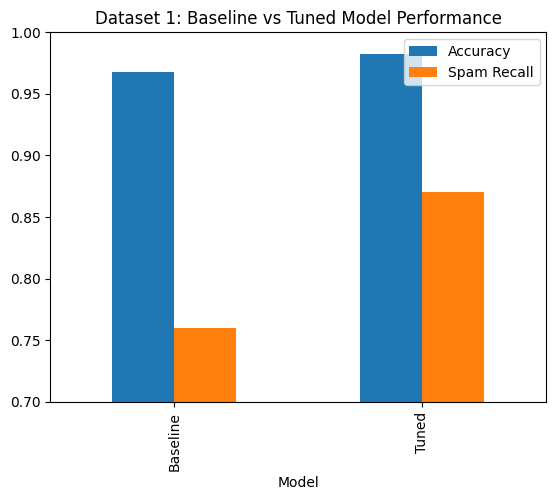

In [15]:
results_df.plot(
    x="Model",
    y=["Accuracy", "Spam Recall"],
    kind="bar",
    ylim=(0.7, 1.0),
    title="Dataset 1: Baseline vs Tuned Model Performance"
)

## Dataset 1 Summary
The SMS Spam dataset serves as the primary experiment in this project. While the baseline model already achieves high accuracy, hyperparameter optimization leads to a clear improvement in spam recall and overall performance. These results demonstrate the effectiveness of tuning for reducing false negatives in spam detection.